I have Refered this project from 
https://www.kaggle.com/kevinchan1986/demystifying-employee-attrition
 for learning purpose. 

#import Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action ='ignore',category=FutureWarning)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,roc_curve,recall_score
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load Datasets

In [2]:
empdf=pd.read_csv('/content/drive/MyDrive/HrDataset/general_data.csv');
empsurvey=pd.read_csv('/content/drive/MyDrive/HrDataset/employee_survey_data.csv');
mngsurvey=pd.read_csv('/content/drive/MyDrive/HrDataset/manager_survey_data.csv');

In [3]:
empdf.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


In [4]:
empsurvey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [5]:
empsurvey.describe()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4410.000000,4385.000000,4390.000000,4372.000000
mean,2205.500000,2.723603,2.728246,2.761436
std,1273.201673,1.092756,1.101253,0.706245
min,1.000000,1.000000,1.000000,1.000000
25%,1103.250000,2.000000,2.000000,2.000000
50%,2205.500000,3.000000,3.000000,3.000000
75%,3307.750000,4.000000,4.000000,3.000000
max,4410.000000,4.000000,4.000000,4.000000


In [6]:
mngsurvey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [7]:
mngsurvey.describe()

,EmployeeID,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000
mean,2205.500000,2.729932,3.153741
std,1273.201673,0.711400,0.360742
min,1.000000,1.000000,3.000000
25%,1103.250000,2.000000,3.000000
50%,2205.500000,3.000000,3.000000
75%,3307.750000,3.000000,3.000000
max,4410.000000,4.000000,4.000000


#merge the datasets to one on employee id

In [8]:
df = pd.merge(pd.merge(empdf, empsurvey, on = 'EmployeeID'), mngsurvey, on = 'EmployeeID')

In [9]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [10]:
df.shape

(4410, 29)

In [11]:
df.info

<bound method DataFrame.info of       Age Attrition  ... JobInvolvement PerformanceRating
0      51        No  ...              3                 3
1      31       Yes  ...              2                 4
2      32        No  ...              3                 3
3      38        No  ...              2                 3
4      32        No  ...              3                 3
...   ...       ...  ...            ...               ...
4405   42        No  ...              3                 3
4406   29        No  ...              2                 3
4407   25        No  ...              3                 4
4408   42        No  ...              2                 3
4409   40        No  ...              4                 3

[4410 rows x 29 columns]>

#Data Preprocessing
## duplicated employee id check

In [12]:
dupcheck=df['EmployeeID'].nunique()- df['EmployeeID'].count()
print('no of duplicate demployee record')
print(dupcheck)

no of duplicate demployee record
0


#Identify thr columns with null values

In [13]:
nullcount=df.isnull().sum()
nullcheck=nullcount[nullcount>0]
print('these are columns containg null values ')
print(nullcheck)

these are columns containg null values 
NumCompaniesWorked         19
TotalWorkingYears           9
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64


In [14]:
df.fillna(df.median(),inplace=True)

In [15]:
nullcount=df.isnull().sum()
nullcheck=nullcount[nullcount>0]
print('these are columns containg null values ')
if nullcheck.empty == False:
  print(nullcheck)
else:
  print("no more columns with null values")

these are columns containg null values 
no more columns with null values


##check if there are any columns with just 1unique value(that feature is not useful , so can remove)

In [16]:
uniquecount=df.nunique()
uniquecheck=uniquecount[uniquecount==1]
print(uniquecheck)

EmployeeCount    1
Over18           1
StandardHours    1
dtype: int64


###Removed the above column

In [17]:
df=df.drop(columns=['EmployeeCount','Over18','StandardHours','EmployeeID'])

In [18]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


#Feature engineering

In [19]:
df['AvgEmpscore']= round(df[['EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance']].mean(axis=1),1)

In [20]:
df['AvgMgrScore']=round(df[['JobInvolvement','PerformanceRating']].mean(axis=1),1)

In [21]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgEmpscore,AvgMgrScore
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,3.0,3.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,3.0,3.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,1.7,3.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,3.7,2.5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,2.7,3.0


#EDA

##visualising the distribution of key categorical data



Text(0.5, 1.0, 'Distribution by gender')

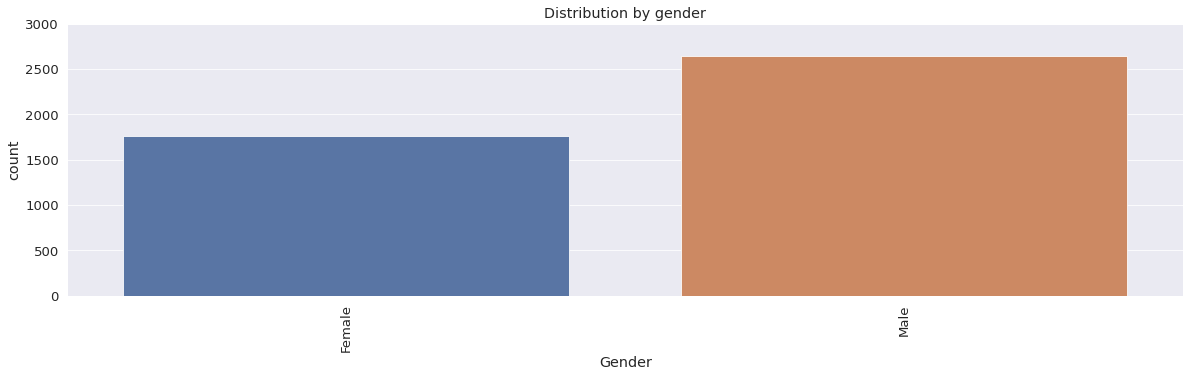

In [22]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
#plt.subplot(1,5,1)
sns.countplot(df['Gender'])
plt.xticks(rotation=90)
plt.ylim((0,3000))
plt.title("Distribution by gender")

##male employees are more than female

Text(0.5, 1.0, 'Distribution of attritin')

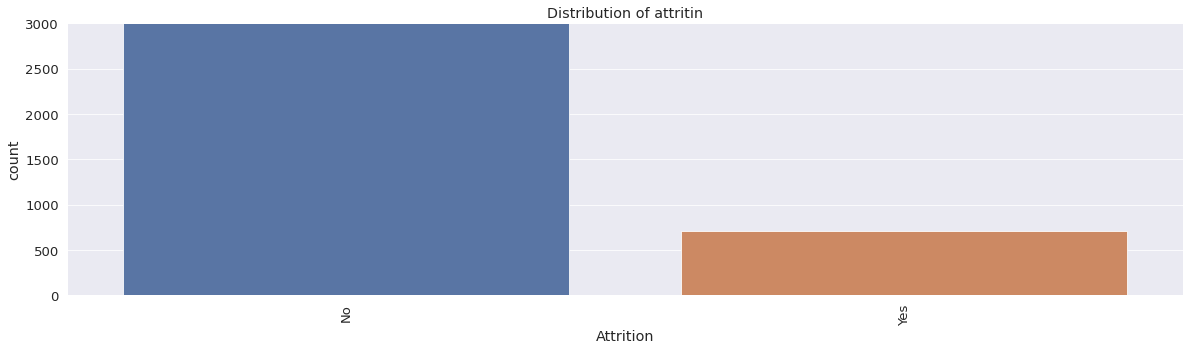

In [23]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
sns.countplot(df['Attrition'])
plt.xticks(rotation=90)
plt.ylim((0,3000))
plt.title("Distribution of attritin")

Text(0.5, 1.0, 'Distribution by Department')

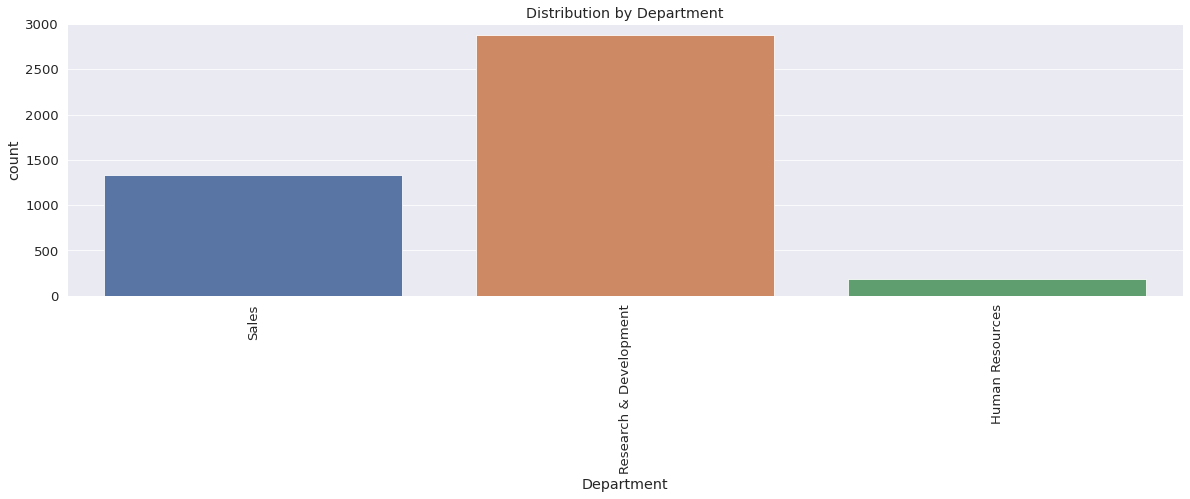

In [24]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
sns.countplot(df['Department'])
plt.xticks(rotation=90)
plt.ylim((0,3000))
plt.title("Distribution by Department")

Text(0.5, 1.0, 'Distribution by joblevel')

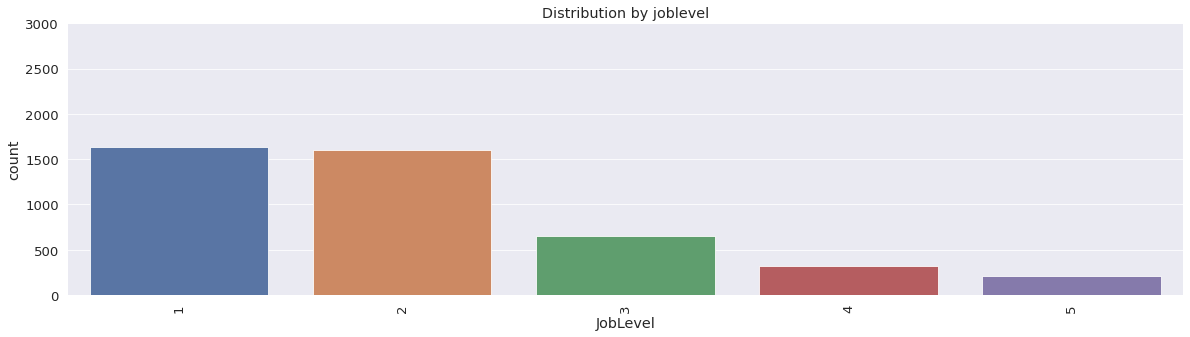

In [25]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
sns.countplot(df['JobLevel'])
plt.xticks(rotation=90)
plt.ylim((0,3000))
plt.title("Distribution by joblevel")

Text(0.5, 1.0, 'Distribution by travel')

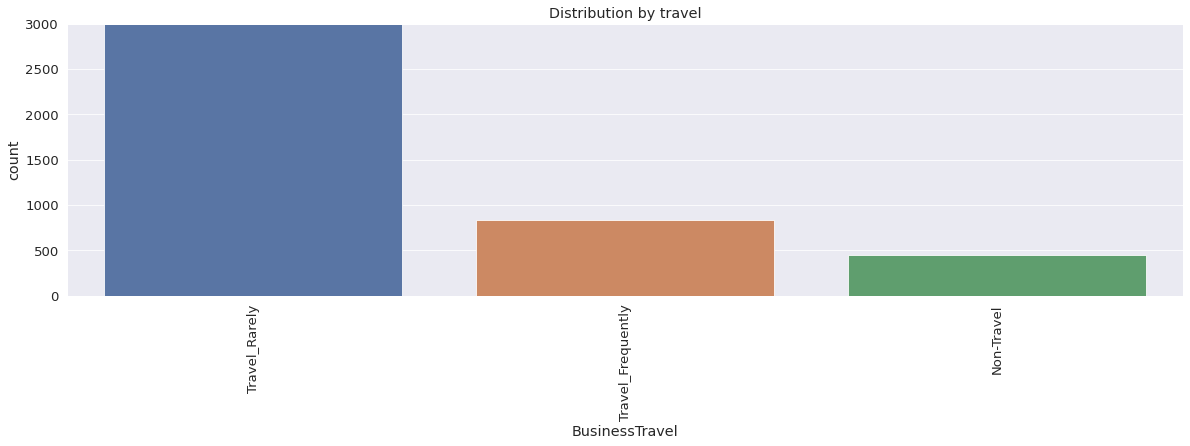

In [26]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
sns.countplot(df['BusinessTravel'])
plt.xticks(rotation=90)
plt.ylim((0,3000))
plt.title("Distribution by travel")

##observation<br>
there are many married employess than single as well as devorced <br>
Most  employees in reserch and developement <br>
Details of job level is not there , based on the data job level increses according to seniority ie 5 is senionr<br>
most employees no need to travel that much . some of them only need to ravel<br>



#disribution of the data with impact on attrition

Text(0.5, 1.0, 'Distribution by age')

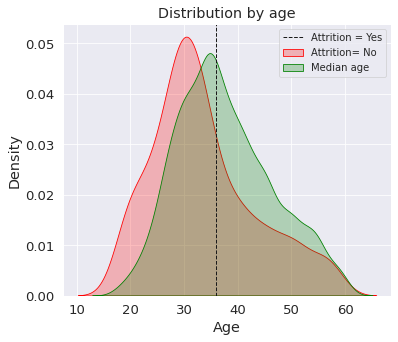

In [27]:

sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.kdeplot(data=df['Age'][df.Attrition == 'Yes'],color='red',shade=True)
sns.kdeplot(data=df['Age'][df.Attrition == 'No'],color='green',shade=True)
plt.axvline(df['Age'].median(),color='k',linestyle='dashed',linewidth=1)
plt.legend(['Attrition = Yes' ,'Attrition= No','Median age'],prop={'size':10})
# plt.yticks([])
plt.title('Distribution by age')

Text(0.5, 1.0, 'Auverage emp score')

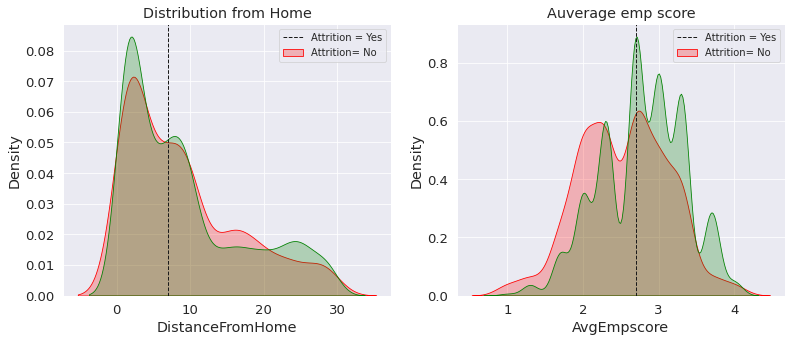

In [28]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.kdeplot(data=df['DistanceFromHome'][df.Attrition == 'Yes'],color='red',shade=True)
sns.kdeplot(data=df['DistanceFromHome'][df.Attrition == 'No'],color='green',shade=True)
plt.axvline(df['DistanceFromHome'].median(),color='k',linestyle='dashed',linewidth=1)
plt.legend(['Attrition = Yes' ,'Attrition= No'],prop={'size':10})
# plt.yticks([])
plt.title('Distribution from Home')


plt.subplot(1,3,2)
sns.kdeplot(data=df['AvgEmpscore'][df.Attrition == 'Yes'],color='red',shade=True)
sns.kdeplot(data=df['AvgEmpscore'][df.Attrition == 'No'],color='green',shade=True)
plt.axvline(df['AvgEmpscore'].median(),color='k',linestyle='dashed',linewidth=1)
plt.legend(['Attrition = Yes' ,'Attrition= No'],prop={'size':10})
# plt.yticks([])
plt.title('Auverage emp score')

#Observations <br>
a.median of age is 36. younget the employee seems to have risk of attrition <br>
b.the median is 7 km .Employees living further from seems to have risk of attrition <br>
c.Median avgempscore is about 2.7 Employee who scored the employee survey with lower scores seems to have high risk of attrition <br>

Text(0.5, 1.0, 'Years Since Last Promotion')

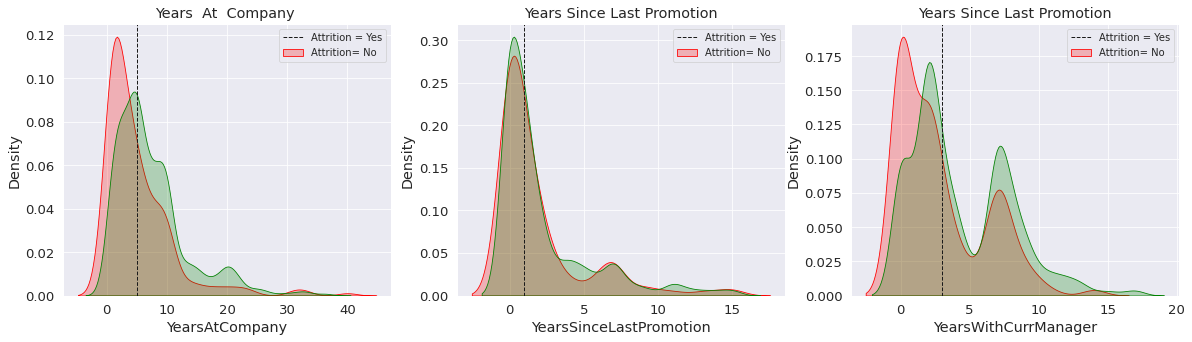

In [29]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.kdeplot(data=df['YearsAtCompany'][df.Attrition == 'Yes'],color='red',shade=True)
sns.kdeplot(data=df['YearsAtCompany'][df.Attrition == 'No'],color='green',shade=True)
plt.axvline(df['YearsAtCompany'].median(),color='k',linestyle='dashed',linewidth=1)
plt.legend(['Attrition = Yes' ,'Attrition= No'],prop={'size':10})
# plt.yticks([])
plt.title('Years  At  Company ')


plt.subplot(1,3,2)
sns.kdeplot(data=df['YearsSinceLastPromotion'][df.Attrition == 'Yes'],color='red',shade=True)
sns.kdeplot(data=df['YearsSinceLastPromotion'][df.Attrition == 'No'],color='green',shade=True)
plt.axvline(df['YearsSinceLastPromotion'].median(),color='k',linestyle='dashed',linewidth=1)
plt.legend(['Attrition = Yes' ,'Attrition= No'],prop={'size':10})
# plt.yticks([])
plt.title('Years Since Last Promotion')

plt.subplot(1,3,3)
sns.kdeplot(data=df['YearsWithCurrManager'][df.Attrition == 'Yes'],color='red',shade=True)
sns.kdeplot(data=df['YearsWithCurrManager'][df.Attrition == 'No'],color='green',shade=True)
plt.axvline(df['YearsWithCurrManager'].median(),color='k',linestyle='dashed',linewidth=1)
plt.legend(['Attrition = Yes' ,'Attrition= No'],prop={'size':10})
# plt.yticks([])
plt.title('Years Since Last Promotion')

#observations
a.median of years at company is 5 the new employes that is less than 5 years at that company ave chances of attrition .
<br>
b. Median years since last prmotion is 1 year . Employees who were recenty promoted seems to have high risk of attrition.
<br>
c.Median years with current manager is 3 year . employees who spend lesser years with current manager seems to have higher risk of attrition.<br> 

Text(0.5, 1.0, 'Distribu')

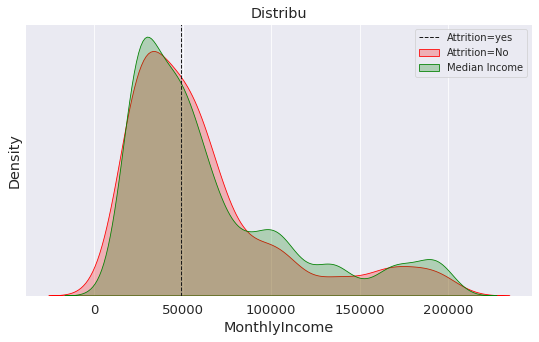

In [30]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.kdeplot(data=df['MonthlyIncome'][df.Attrition=='Yes'],color='red',shade=True)
sns.kdeplot(data=df['MonthlyIncome'][df.Attrition=='No'],color='green',shade=True)
plt.axvline(df['MonthlyIncome'].median(),color='k',linestyle='dashed',linewidth=1)
plt.legend(['Attrition=yes','Attrition=No','Median Income'],prop={'size':10})
plt.yticks([])
plt.title('Distribu')

Median MonthlyIncome is around 50,000 Rupees. Employees who are paid lower than 80,000 Rupees seem to have a slightly higher risk of attrition. However, the observed difference is not as visually significant compared to features explored earlier.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'MonthlyIncome vs. DistanceFromHome (of Attrition = No)')

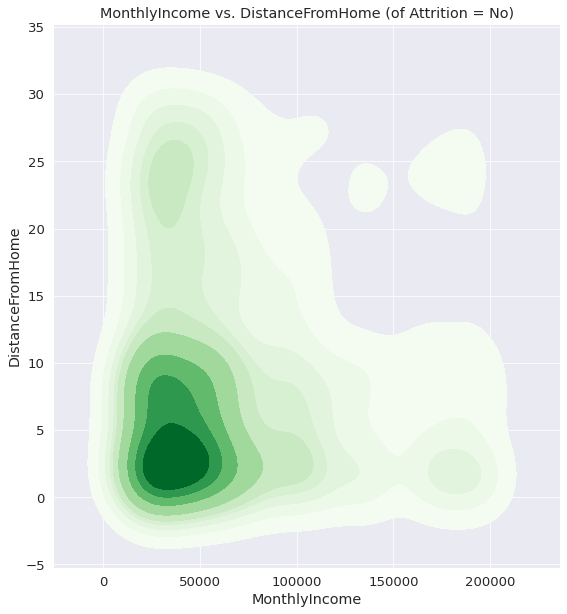

In [31]:
sns.set(context="paper", font_scale=1.5)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.kdeplot(data=df['MonthlyIncome'][df.Attrition == 'No'], data2=df['DistanceFromHome'][df.Attrition == 'No'], cmap="Greens", shade=True, shade_lowest=False)
plt.title('MonthlyIncome vs. DistanceFromHome (of Attrition = No)')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'MonthlyIncome vs. DistanceFromHome (of Attrition = Yes)')

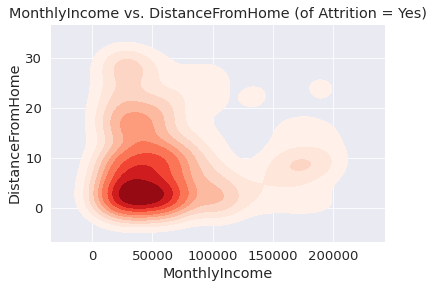

In [32]:
sns.kdeplot(data=df['MonthlyIncome'][df.Attrition == 'Yes'], data2=df['DistanceFromHome'][df.Attrition == 'Yes'], cmap="Reds", shade=True, shade_lowest=False)
plt.title('Distribution of MonthlyIncome')
plt.title('MonthlyIncome vs. DistanceFromHome (of Attrition = Yes)')

<br>
1.most of the employees who lived further away from office are paid around median monthlyincome of 50,000 rupees . they also exhibit higher risk of attrition <br>
2. employees who are paid 3x more than median are also exhibiting higher risk of attrition if hey live beyond 5 km of the office 

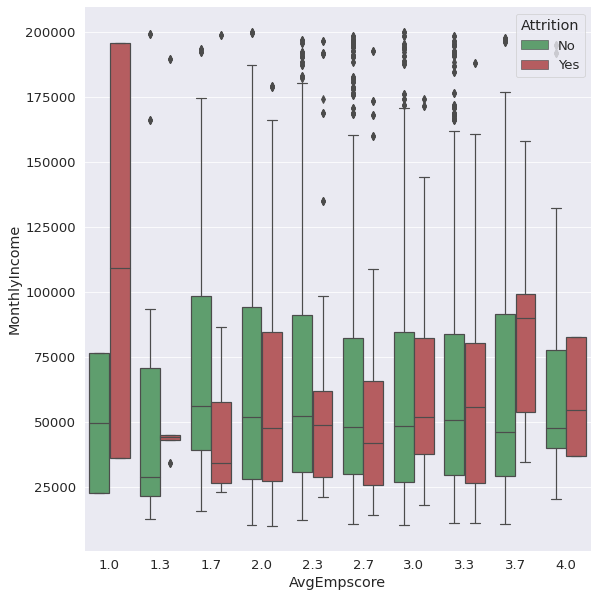

In [33]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.boxplot(x="AvgEmpscore",y="MonthlyIncome",hue="Attrition",palette=['g','r'],data=df)
plt.legend(loc=1,title='Attrition')
sns.despine()

Text(0.5, 1.0, 'monthlyIncome vs Education')

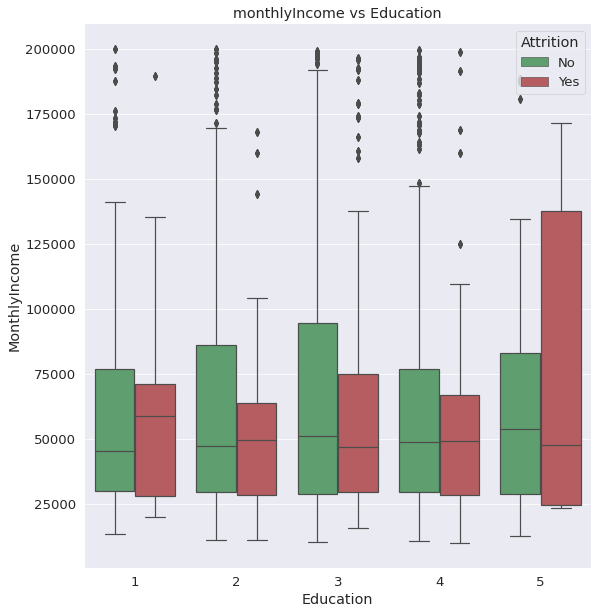

In [34]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.boxplot(x="Education",y="MonthlyIncome",hue="Attrition",palette=['g','r'],data=df)
plt.legend(loc=1,title='Attrition')
sns.despine()
plt.title("monthlyIncome vs Education")

Attrition
No     3699
Yes     711
dtype: int64


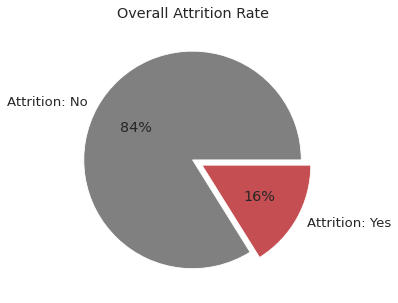

In [35]:
sns.set(context="paper", font_scale=1.5)

Attr = df.groupby(['Attrition']).size()
print(Attr)
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))

ax1.pie(Attr, autopct = '%.0f%%', radius= 1, startangle = 0,labels = ('Attrition: No','Attrition: Yes'),labeldistance = 1.1, colors = ('gray','r'),explode=(0,0.1))
ax1.set_title('Overall Attrition Rate')

plt.show()

##overall attrition rate of the company is 16 %

Text(0.5, 1.0, 'Female attrition rate')

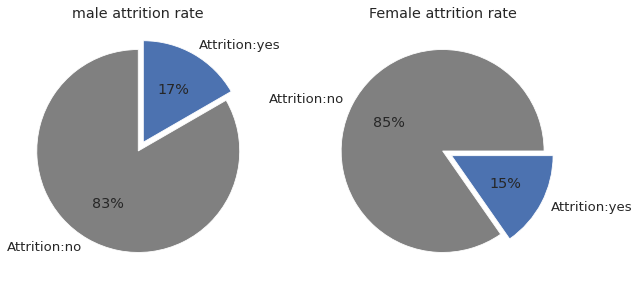

In [36]:
sns.set(context="paper",font_scale=1.5)
male=df[df['Gender']=='Male'].groupby(['Attrition']).size()
female=df[df['Gender']=='Female'].groupby(['Attrition']).size()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
#fig(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))
ax1.pie(male,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax1.set_title("male attrition rate")
ax2.pie(female,autopct='%.0f%%',radius=1,startangle=0,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax2.set_title("Female attrition rate")

#observations<br>
##1.Male attrition rate is higher than female<br> but females are less in number (from previous graphs)

#Graph according the marital status 

Text(0.5, 1.0, 'Divorced attrition rate')

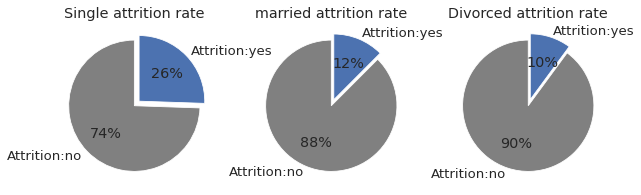

In [37]:
sns.set(context="paper",font_scale=1.5)
single=df[df['MaritalStatus']=='Single'].groupby(['Attrition']).size()
married=df[df['MaritalStatus']=='Married'].groupby(['Attrition']).size()
divorced=df[df['MaritalStatus']=='Divorced'].groupby(['Attrition']).size()

fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,10))
ax1.pie(single,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax2.pie(married,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax3.pie(divorced,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax1.set_title("Single attrition rate")
ax2.set_title("married attrition rate")
ax3.set_title("Divorced attrition rate")

##Attrition rate of the single employees is more 

In [38]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgEmpscore,AvgMgrScore
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,3.0,3.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,3.0,3.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,1.7,3.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,3.7,2.5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,2.7,3.0


Text(0.5, 1.0, 'Hr  attrition rate')

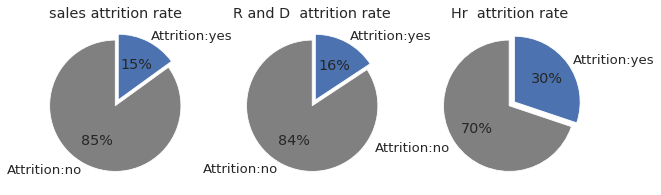

In [39]:
sns.set(context="paper",font_scale=1.5)
sales=df[df['Department']=='Sales'].groupby(['Attrition']).size()
rd=df[df['Department']=='Research & Development'].groupby(['Attrition']).size()
hr=df[df['Department']=='Human Resources'].groupby(['Attrition']).size()

fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,10))
ax1.pie(sales,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax2.pie(rd,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax3.pie(hr,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax1.set_title("sales attrition rate")
ax2.set_title("R and D  attrition rate")
ax3.set_title("Hr  attrition rate")

## the attrition rate is very high in hr department 

In [40]:
df.BusinessTravel.unique()


array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

Text(0.5, 1.0, 'non travel attrition rate')

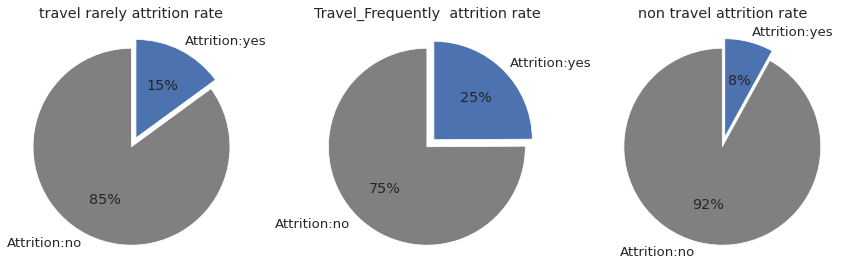

In [41]:
sns.set(context="paper",font_scale=1.5)
Tr=df[df['BusinessTravel']=='Travel_Rarely'].groupby(['Attrition']).size()
Tf=df[df['BusinessTravel']=='Travel_Frequently'].groupby(['Attrition']).size()
Nt=df[df['BusinessTravel']=='Non-Travel'].groupby(['Attrition']).size()

fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,10))
ax1.pie(Tr,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax2.pie(Tf,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax3.pie(Nt,autopct='%.0f%%',radius=1,startangle=90,labels=('Attrition:no','Attrition:yes'),labeldistance=1.1,colors=('gray','b'),explode=(0,0.1))
ax1.set_title("travel rarely attrition rate")
ax2.set_title("Travel_Frequently  attrition rate")
ax3.set_title("non travel attrition rate")

##the people who travel more have high attrition rate

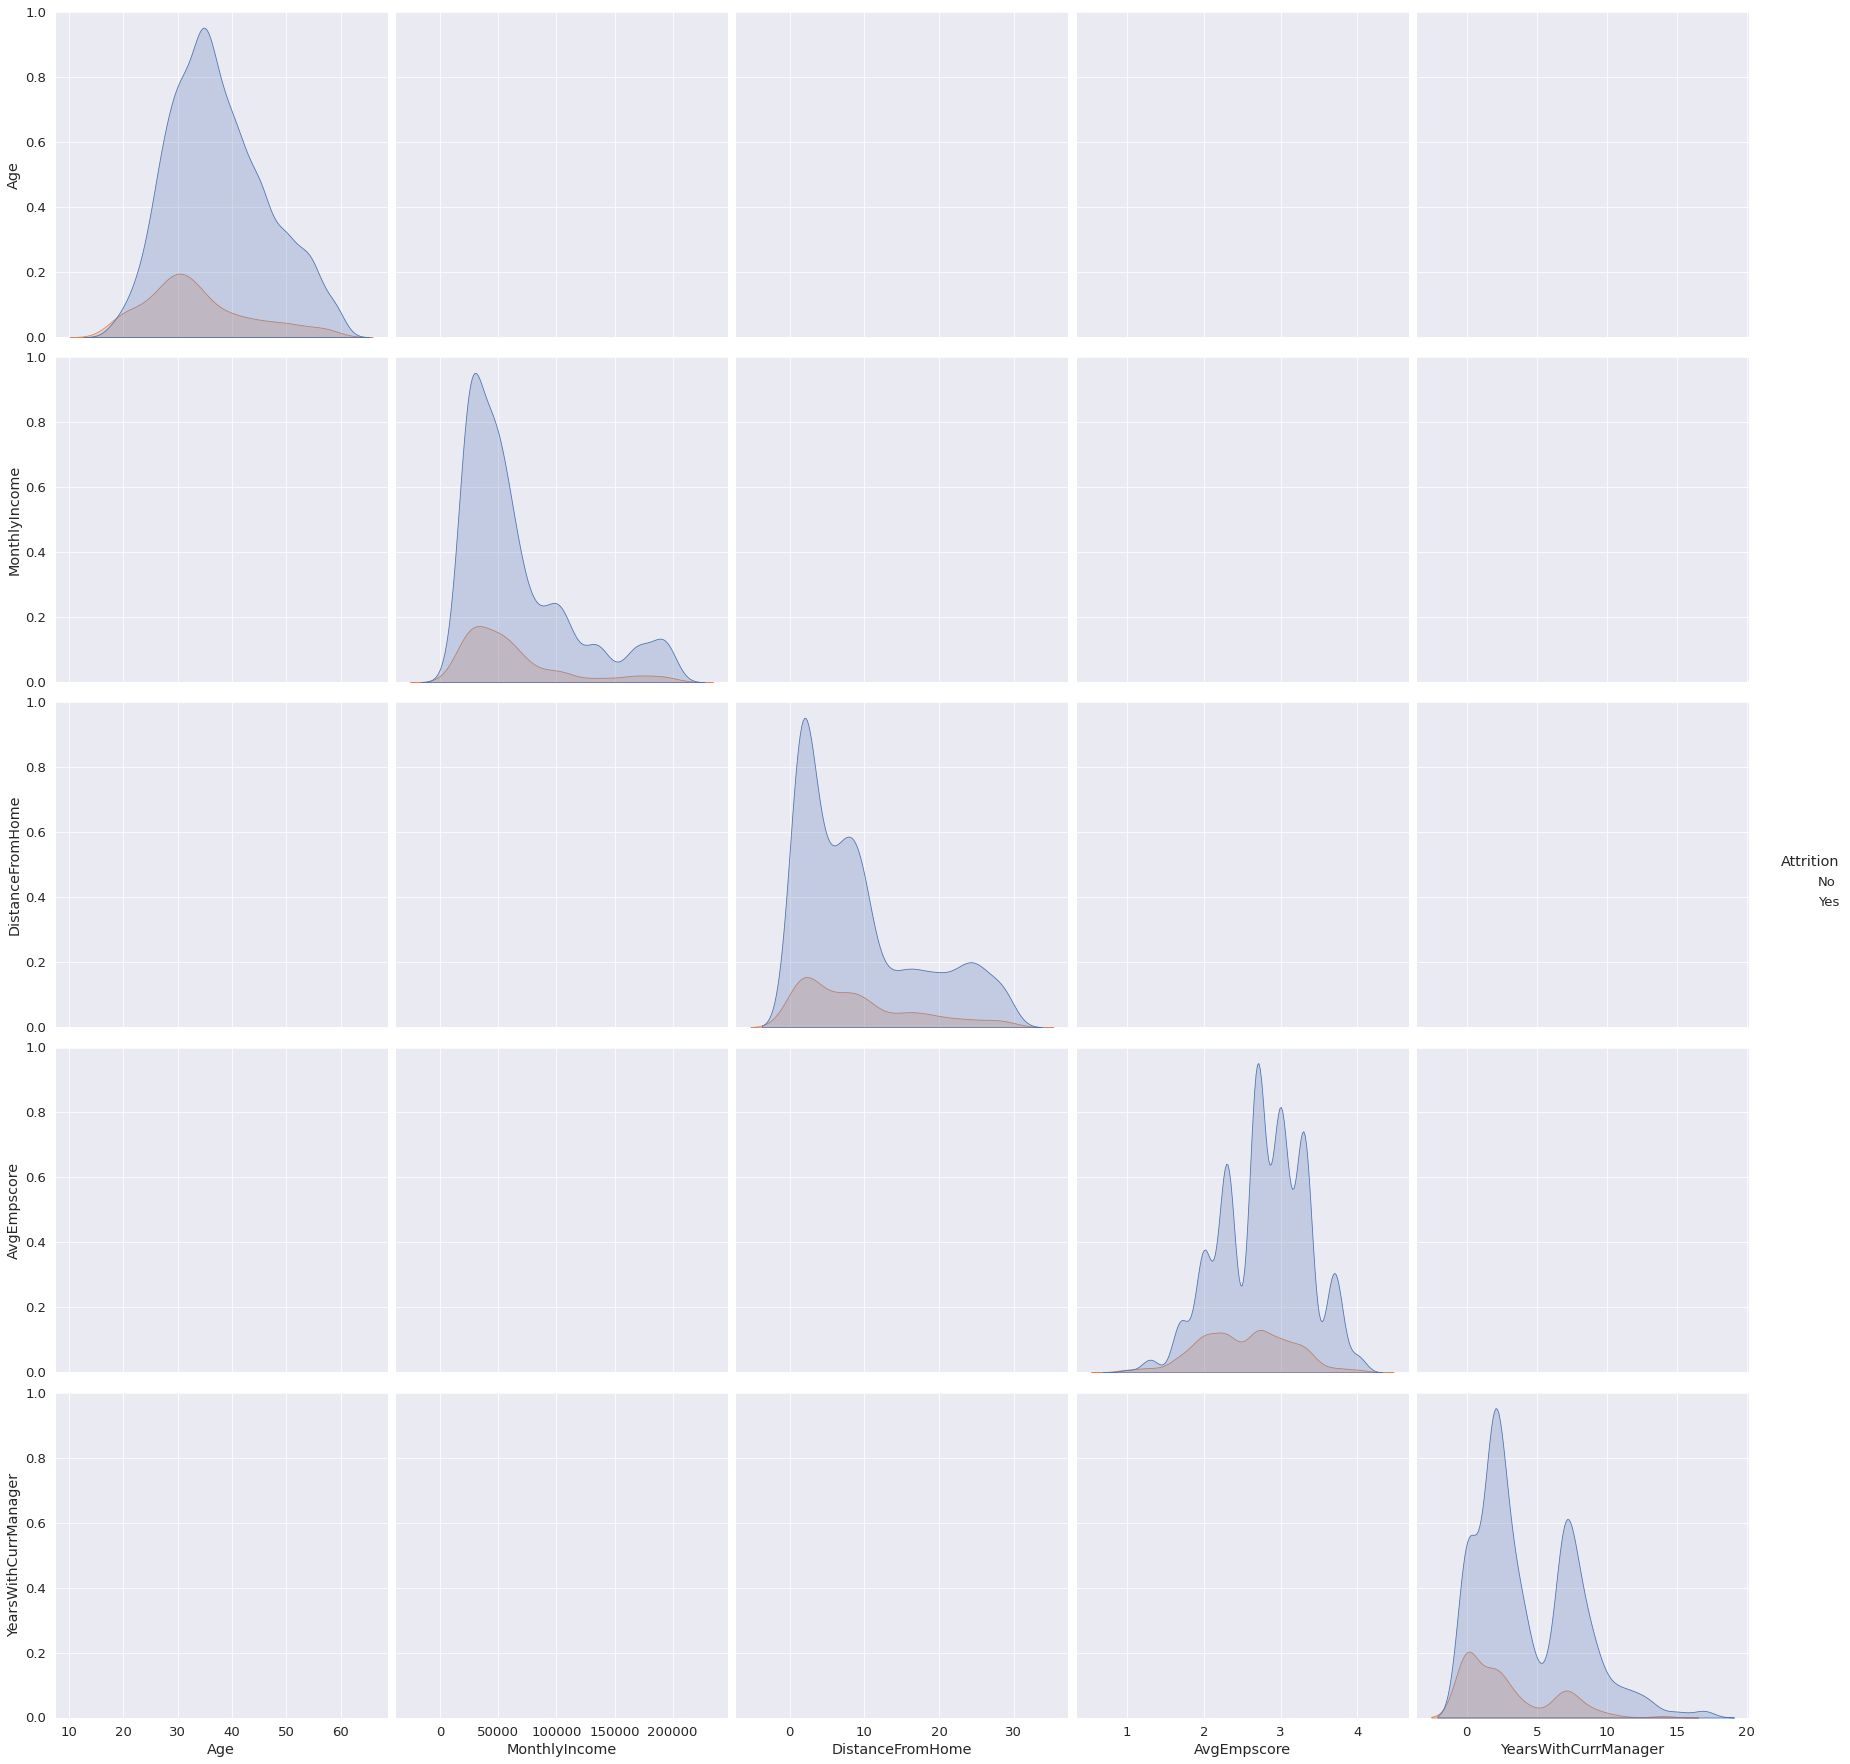

In [42]:
sns.set(context="paper",font_scale=1.5)
sns.pairplot(df[['Age','MonthlyIncome','DistanceFromHome','AvgEmpscore','YearsWithCurrManager','Attrition']],hue='Attrition',height=5,kind="req")

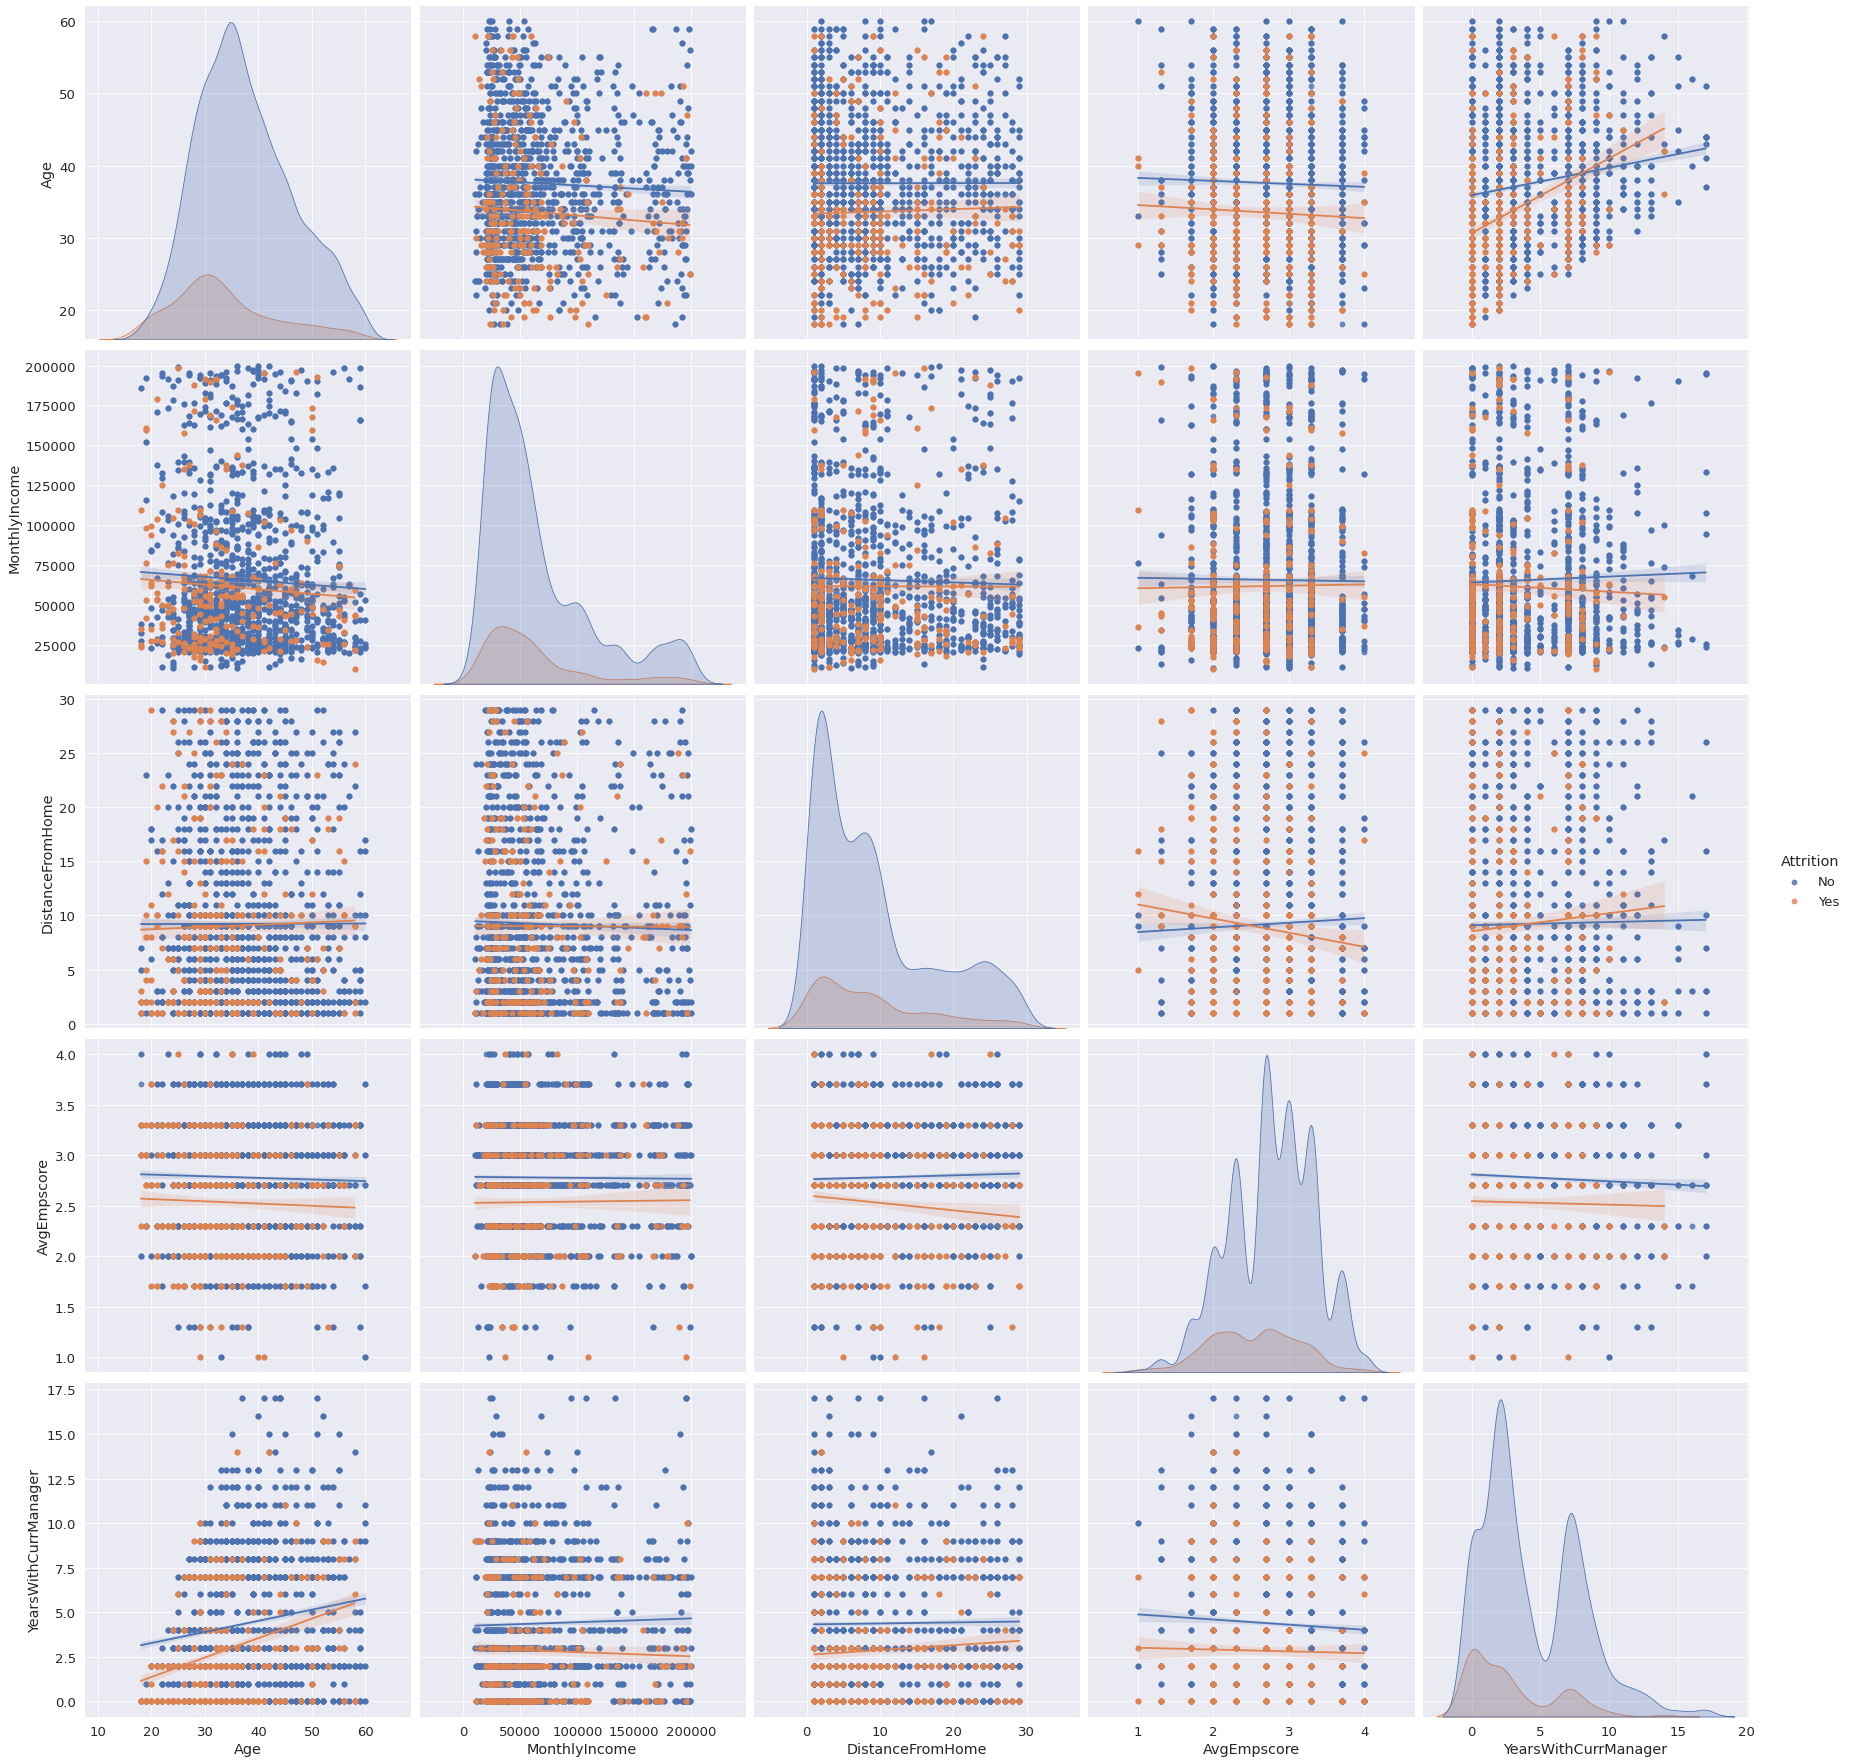

In [43]:
sns.set(context="paper", font_scale=1.5)
sns.pairplot(df[['Age','MonthlyIncome','DistanceFromHome','AvgEmpscore','YearsWithCurrManager','Attrition']],hue = 'Attrition', height = 5, kind="reg")
plt.show()

#Preparing df for the ML

In [44]:
df_num=df.copy()
df_num.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgEmpscore,AvgMgrScore
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,3.0,3.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,3.0,3.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,1.7,3.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,3.7,2.5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,2.7,3.0


Identifying categorica coulmns

In [45]:
catcoldf=df.select_dtypes(include='object')
print(catcoldf)
catcolname=list(catcoldf.columns.values)
catcolname

     Attrition     BusinessTravel  ...                    JobRole MaritalStatus
0           No      Travel_Rarely  ...  Healthcare Representative       Married
1          Yes  Travel_Frequently  ...         Research Scientist        Single
2           No  Travel_Frequently  ...            Sales Executive       Married
3           No         Non-Travel  ...            Human Resources       Married
4           No      Travel_Rarely  ...            Sales Executive        Single
...        ...                ...  ...                        ...           ...
4405        No      Travel_Rarely  ...         Research Scientist        Single
4406        No      Travel_Rarely  ...      Laboratory Technician      Divorced
4407        No      Travel_Rarely  ...            Sales Executive       Married
4408        No      Travel_Rarely  ...      Laboratory Technician      Divorced
4409        No      Travel_Rarely  ...      Laboratory Technician      Divorced

[4410 rows x 7 columns]


['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus']

Transforming the categorical features into numerical features using get_dummies function in Pandas in order for these features to be used by machine learning algorithms



In [46]:
df_num=pd.get_dummies(df_num)
df_num

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgEmpscore,AvgMgrScore,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,6,2,1,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,3.0,3.0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
1,31,10,1,1,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,3.0,3.0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,32,17,4,4,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,1.7,3.0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3,38,2,5,3,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,3.7,2.5,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4,32,10,1,1,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,2.7,3.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,5,4,1,60290,3.0,17,1,10.0,5,3,0,2,4.0,1.0,3.0,3,3,2.7,3.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4406,29,2,4,1,26790,2.0,15,0,10.0,2,3,0,2,4.0,4.0,3.0,2,3,3.7,2.5,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4407,25,25,2,2,37020,0.0,20,0,5.0,4,4,1,2,1.0,3.0,3.0,3,4,2.3,3.5,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4408,42,18,2,1,23980,0.0,14,1,10.0,2,9,7,8,4.0,1.0,3.0,2,3,2.7,2.5,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


plotting correlation matrix to identify feature-pair with high correlation with each other

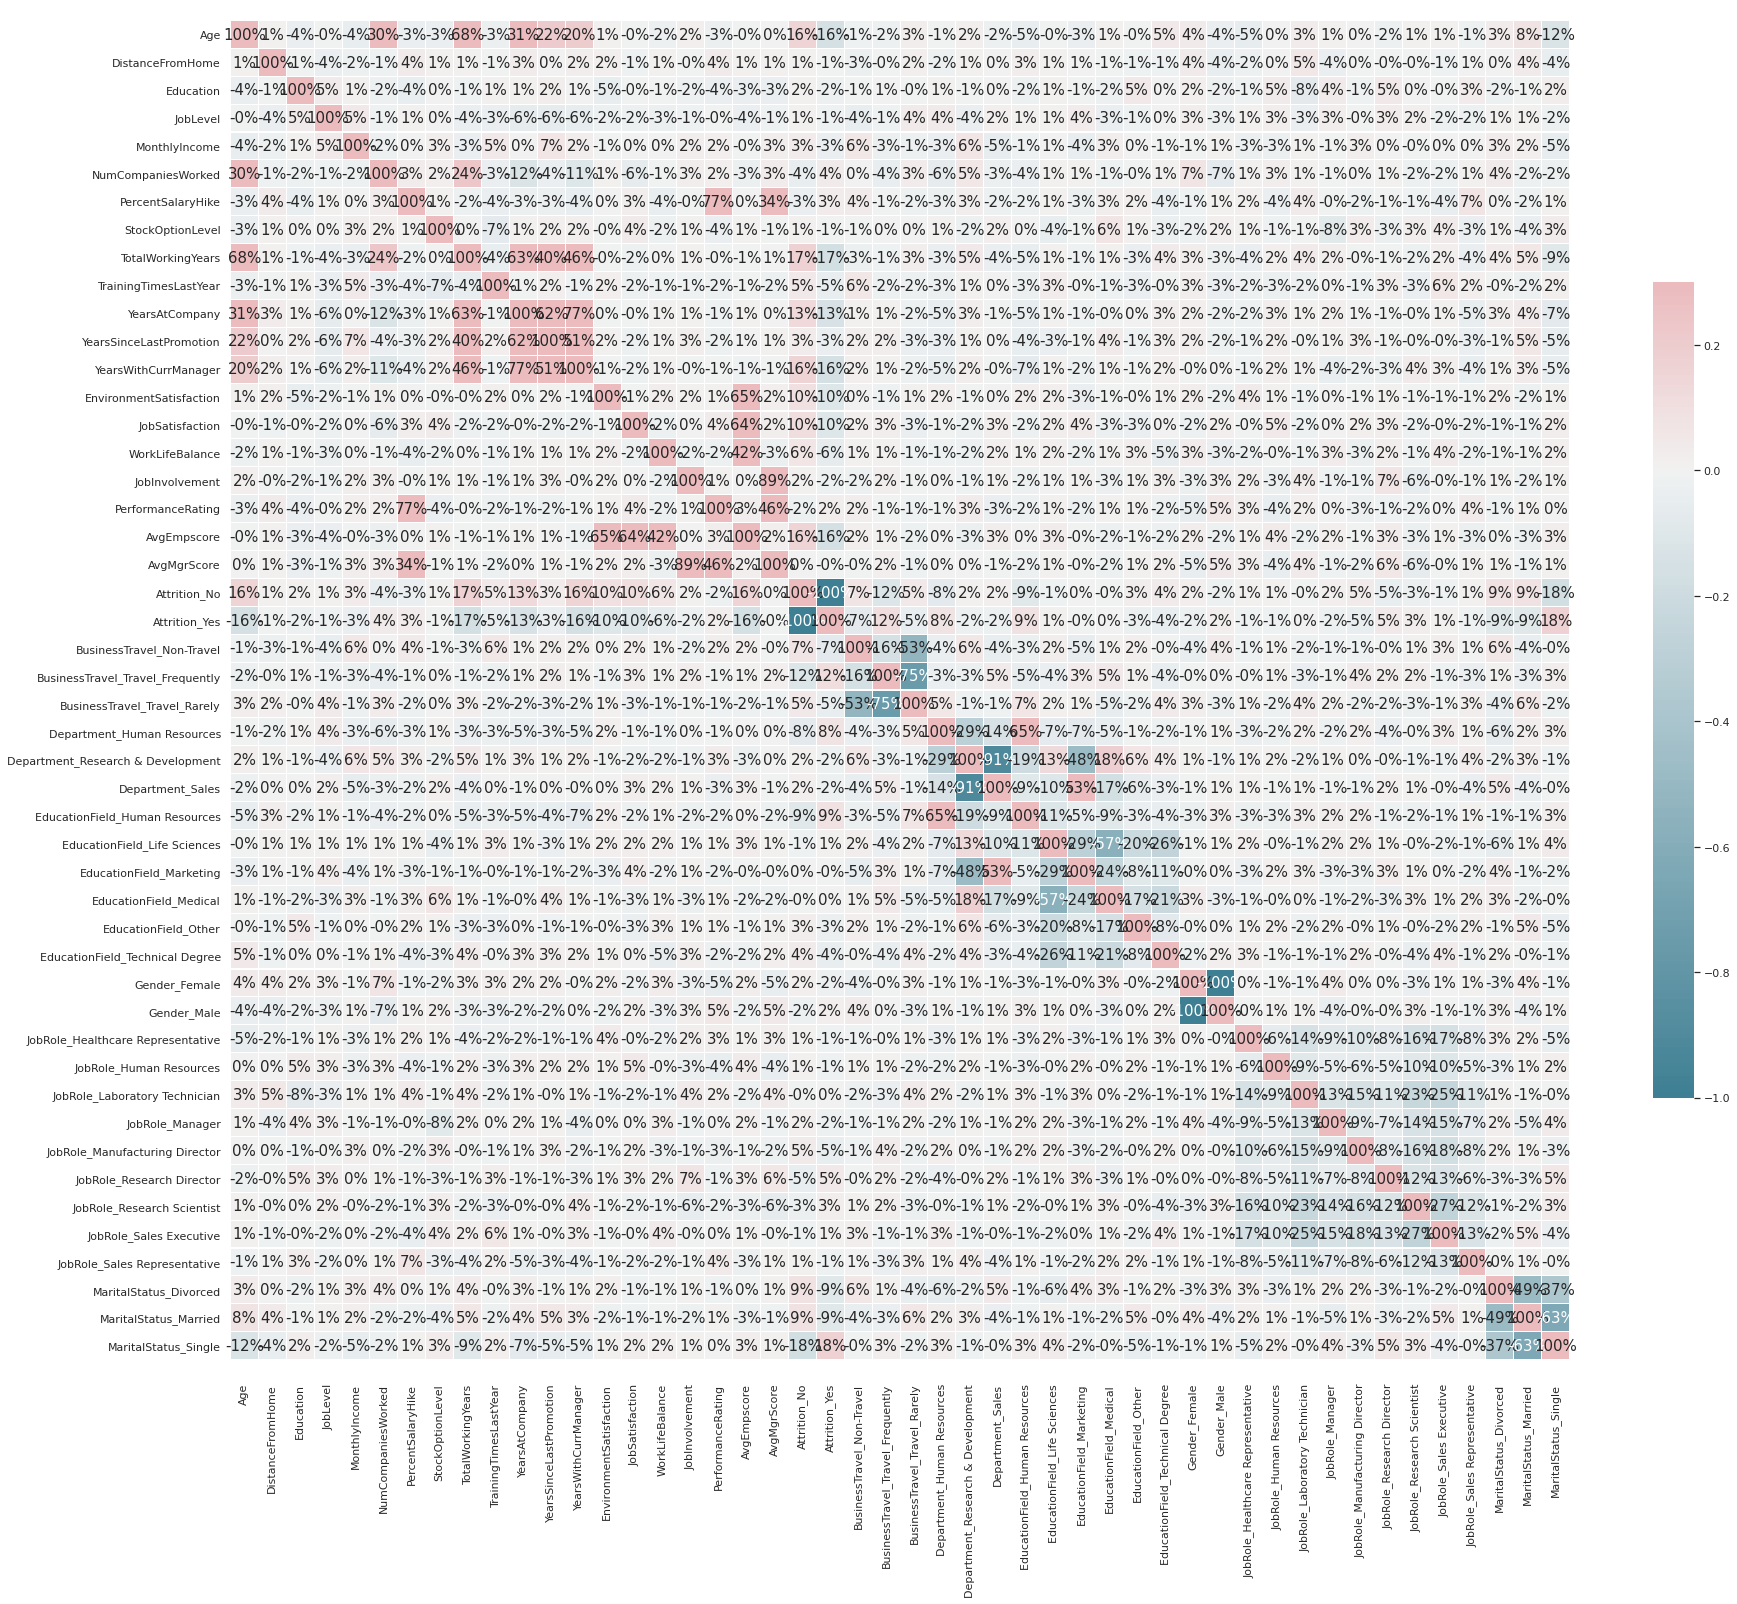

In [47]:
sns.set(style="white")
corr = df_num.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cm = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,annot=True, fmt=".0%", square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot_kws={"size": 15})
bottom, top = cm.get_ylim()
cm.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [48]:
highcorrel = set()
correlmatrix = df_num.corr()
print(correlmatrix)

for x in range(len(correlmatrix.columns)):
    for y in range(x):
        if abs(correlmatrix.iloc[x, y]) > 0.7:
            colname = correlmatrix.columns[y]
            highcorrel.add(colname)

highcorrel

                                        Age  ...  MaritalStatus_Single
Age                                1.000000  ...             -0.119185
DistanceFromHome                   0.006963  ...             -0.042204
Education                         -0.035706  ...              0.024114
JobLevel                          -0.002884  ...             -0.021163
MonthlyIncome                     -0.044314  ...             -0.051774
NumCompaniesWorked                 0.298869  ...             -0.020569
PercentSalaryHike                 -0.033137  ...              0.013365
StockOptionLevel                  -0.031753  ...              0.032327
TotalWorkingYears                  0.680340  ...             -0.089256
TrainingTimesLastYear             -0.027308  ...              0.019602
YearsAtCompany                     0.311309  ...             -0.070935
YearsSinceLastPromotion            0.216513  ...             -0.053090
YearsWithCurrManager               0.202089  ...             -0.047793
Enviro

{'Attrition_No',
 'BusinessTravel_Travel_Frequently',
 'Department_Research & Development',
 'Gender_Female',
 'JobInvolvement',
 'PercentSalaryHike',
 'YearsAtCompany'}

In [49]:
df_num = df_num.drop(columns=highcorrel)


In [50]:
df_num.columns

Index(['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'PerformanceRating', 'AvgEmpscore', 'AvgMgrScore',
       'Attrition_Yes', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRo

#implementin machine learnig alogoithms

#LOGISTIC REGRESSION

In [51]:
X=df_num.drop('Attrition_Yes',axis=1)
y=df_num['Attrition_Yes']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=1)
ss=preprocessing.StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

In [52]:
#lrstart=timer()
lr=LogisticRegression(random_state=1)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

##model evaluation and perfomance

In [53]:
from sklearn import metrics
lraccuracy=accuracy_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
# lrroc_auc=auc(fpr,tpr)
# lrroc_auc = auc(fpr, tpr)
lrroc_auc = np.trapz(fpr, tpr)

lrf1_score=f1_score(y_test,y_pred)
lrrecall=recall_score(y_test,y_pred)

print("Model accuracy is ", lraccuracy)
print("Roc_Auc score : ",lrroc_auc)
print("F1 score: ",lrf1_score)
print("Recall Score: ",lrrecall)

Model accuracy is  0.8412698412698413
Roc_Auc score :  0.42794944965348547
F1 score:  0.2605633802816901
Recall Score:  0.16591928251121077


#confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix

# After a train/test split:
confusion_matrix(y_test, y_pred)

array([[1076,   24],
       [ 186,   37]])

<h2>Conclusion</h2>

Model Accuracy is 84% <br>
f1 score is unacceptable at 26% that is bad.so need to reject the model


#LOGISTIC REGRESSION

In [55]:
X = df_num.drop('Attrition_Yes', axis =1)
y = df_num['Attrition_Yes']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state =1)

ss = preprocessing.StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [56]:
lrtuned = LogisticRegression(random_state=1, class_weight="balanced")

lrtuned.fit(X_train, y_train)

y_pred = lrtuned.predict(X_test)

In [57]:
from sklearn import metrics
lraccuracy=accuracy_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
# lrroc_auc=auc(fpr,tpr)
# lrroc_auc = auc(fpr, tpr)
lrroc_auc = np.trapz(fpr, tpr)

lrf1_score=f1_score(y_test,y_pred)
lrrecall=recall_score(y_test,y_pred)

print("Model accuracy is ", lraccuracy)
print("Roc_Auc score : ",lrroc_auc)
print("F1 score: ",lrf1_score)
print("Recall Score: ",lrrecall)

Model accuracy is  0.6893424036281179
Roc_Auc score :  0.3030126375866286
F1 score:  0.4346629986244842
Recall Score:  0.7085201793721974


In [58]:
confusion_matrix(y_test,y_pred)

array([[754, 346],
       [ 65, 158]])

Model accuracy is dropped to 68 %<br>
f1 score is improved still not good 

In [59]:
lrtunedcoef=[]
for i in range(len(lrtuned.coef_)):
  for j in range(len(lrtuned.coef_[0])):
    featcoef=(lrtuned.coef_[0][j])
    lrtunedcoef.append(featcoef)

colname=X.columns.values
lrtunedtopfeat=pd.DataFrame(data=lrtunedcoef,index=colname,columns=['Coefficient'])
lrtunedtopfeat=lrtunedtopfeat.sort_values(by=['Coefficient'],ascending=False)
lrtunedtopfeat['Positive']=lrtunedtopfeat['Coefficient']>0

NameError: ignored

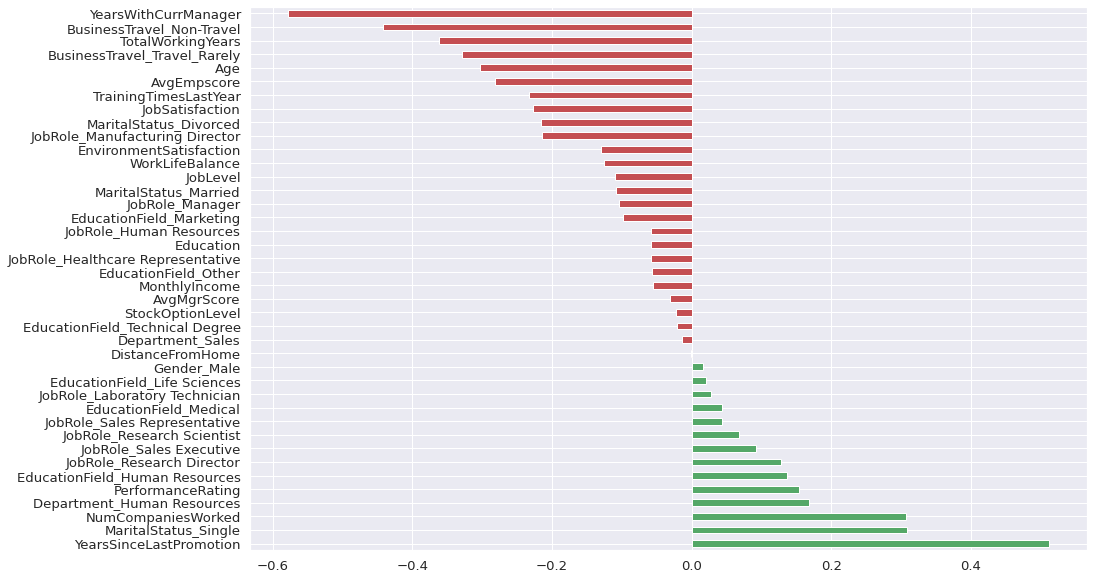

In [60]:
sns.set(context="paper", font_scale=1.2)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.2)
lrtunedtopfeat['Coefficient'].plot(kind='barh', color=lrtunedtopfeat.Positive.map({True: 'g', False: 'r'}))
green = mpatches.Patch(color='g', label = 'Positive Coefficient')
red = mpatches.Patch(color='r', label = 'Negative Coefficient')
plt.gca().invert_yaxis()
plt.legend(handles = [green, red], loc='lower right')
plt.title('Coefficients of ALL Features')
plt.show()

<br>There are more features with negative coefficient compared to the positive coefficients. Those featurs with negative coefficient have an inerese relationship with Attrition Risk
(target variable value =1)
<br>
Using YearswithCurrent manager as an example , this means that years the employee spend with the current manager more likely the employee is to leave the organisation.This coincides with the observation made in Exploratory data analyis section.<br>

NameError: ignored

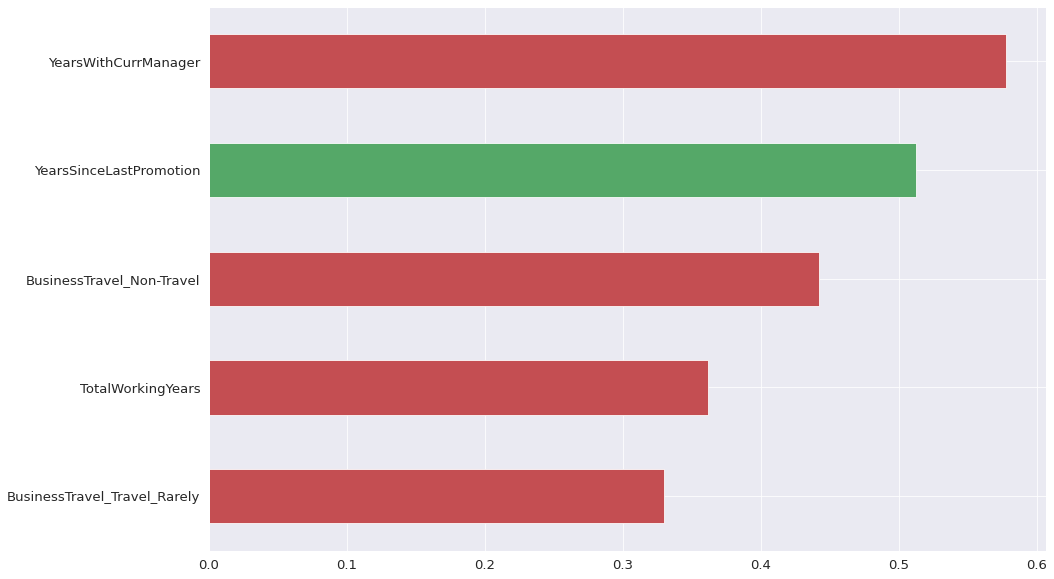

In [61]:
lrtunedtopfeat['AbsCoef']=lrtunedtopfeat['Coefficient'].abs()
lrtunedtopfeat=lrtunedtopfeat.sort_values(by='AbsCoef',ascending=False)[0:5]

sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(15,10))
lrtunedtopfeat['AbsCoef'].plot(kind='barh',color=lrtunedtopfeat.Positive.map({True:'g',False:'r'}))
plt.gca().invert_yaxis()
plt.legend(handles=[green,red],loc='lower right')

plt.title('(Absolute) Coefficients of top 5 features')
plt.show()

#Top 5 features <br>
1.Years with current manager<br>
2.Years since last promotion<br>
3.Bussinesstravel_non_travel<br>
4.TotalWorking days<br>
5.BussinessTravel_travel_Rarely


#RandomForest Classifier

In [62]:
#Performing train test split
X=df_num.drop('Attrition_Yes',axis=1)
y=df_num['Attrition_Yes']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=1)

In [63]:

rf=RandomForestClassifier(n_estimators=100,max_depth=10,max_features=None,random_state=1,class_weight="balanced")
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [64]:
from sklearn import metrics
rfaccuracy=accuracy_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
rfroc_auc=metrics.auc(fpr,tpr)
rff1_score=f1_score(y_test,y_pred)
rfrecall=recall_score(y_test,y_pred)

print("Model accuracy ",rfaccuracy)
print("ROC_AUC score",rfroc_auc)
print("F1 score",rff1_score)
print("Recall score",rfrecall)

Model accuracy  0.9508692365835223
ROC_AUC score 0.9114635140644111
F1 score 0.853932584269663
Recall score 0.852017937219731


#plotting confusion matrix

In [65]:
rfcm=confusion_matrix(y_test,y_pred)
print(rfcm)

[[1068   32]
 [  33  190]]


model accuracy and f1-score of random forest classification improved dramatically over the logistic regression model build earlier.

#Hyper parameter tunning

In [66]:

n_estimators=[4,8,32]
trainf1=[]
testf1=[]
for i in n_estimators:
    rf = RandomForestClassifier(n_estimators=i, random_state=1, class_weight = "balanced")
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    
    f1train = f1_score(y_train, train_pred)
    trainf1.append(f1train)
    
    y_pred = rf.predict(X_test)
    
    f1test = f1_score(y_test, y_pred)
    testf1.append(f1test)

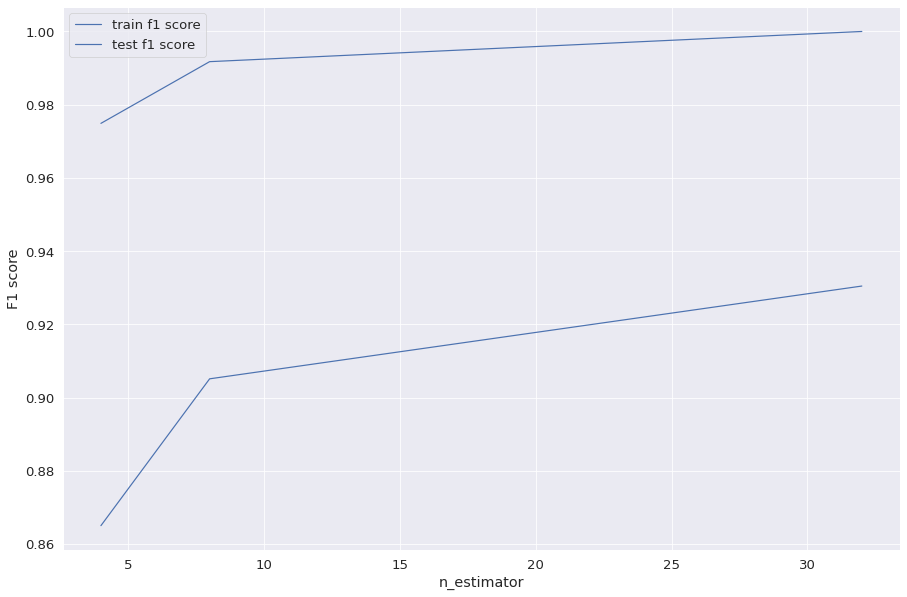

In [67]:
sns.set(context="paper",font_scale=1.5)
plt.figure(figsize=(15,10))
plt.plot(n_estimators,trainf1,'b',label="train f1 score")
plt.plot(n_estimators,testf1,'b',label="test f1 score")
plt.legend()
plt.ylabel('F1 score')
plt.xlabel("n_estimator")
plt.show()

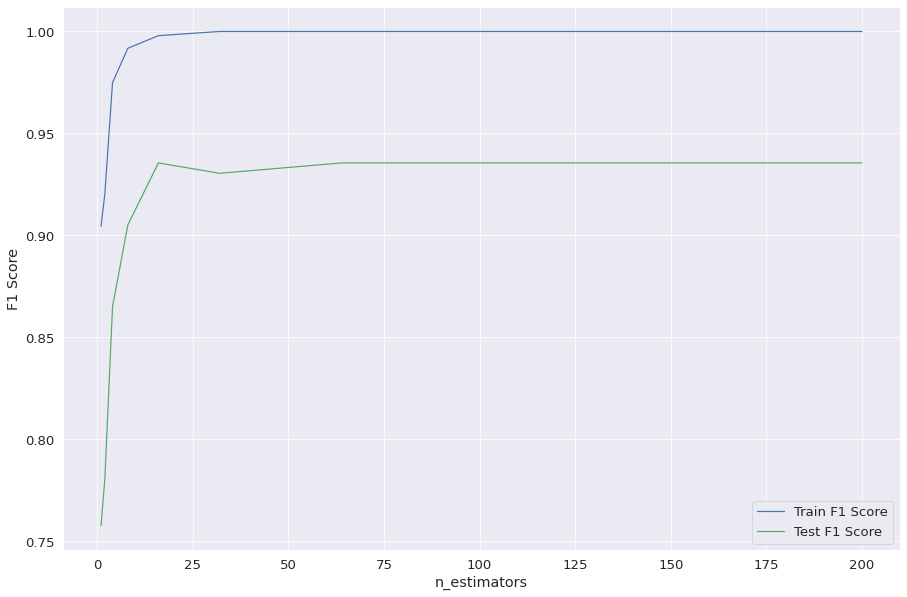

In [68]:

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
trainf1 = []
testf1 = []

for i in n_estimators:
    rf = RandomForestClassifier(n_estimators=i, random_state=1, class_weight = "balanced")
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    
    f1train = f1_score(y_train, train_pred)
    trainf1.append(f1train)
    
    y_pred = rf.predict(X_test)
    
    f1test = f1_score(y_test, y_pred)
    testf1.append(f1test)
    

sns.set(context="paper", font_scale=1.5)
plt.figure(figsize=(15,10))
plt.plot(n_estimators, trainf1, 'b', label= 'Train F1 Score')
plt.plot(n_estimators, testf1, 'g', label= 'Test F1 Score')

plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('n_estimators')
plt.show()

from graph we can see that @ 32 the high accuracy score.

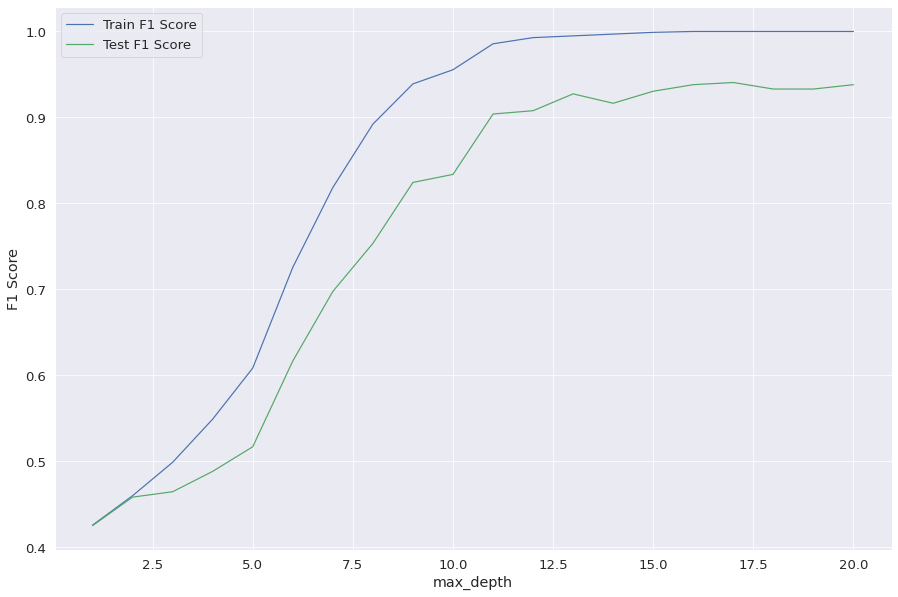

In [69]:
max_depth = np.arange(1,21,1)
trainf1 = []
testf1 = []

for i in max_depth:
    rf = RandomForestClassifier(n_estimators = 32, max_depth=i, random_state=1,class_weight = "balanced")
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    
    f1train = f1_score(y_train, train_pred)
    trainf1.append(f1train)
    
    y_pred = rf.predict(X_test)
    
    f1test = f1_score(y_test, y_pred)
    testf1.append(f1test)

sns.set(context="paper", font_scale=1.5)
plt.figure(figsize=(15,10))
plt.plot(max_depth, trainf1, 'b', label= 'Train F1 Score')
plt.plot(max_depth, testf1, 'g', label= 'Test F1 Score')

plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('max_depth')
plt.show()

from graph we can see that @16 the graph become stable . so can take depth as 16

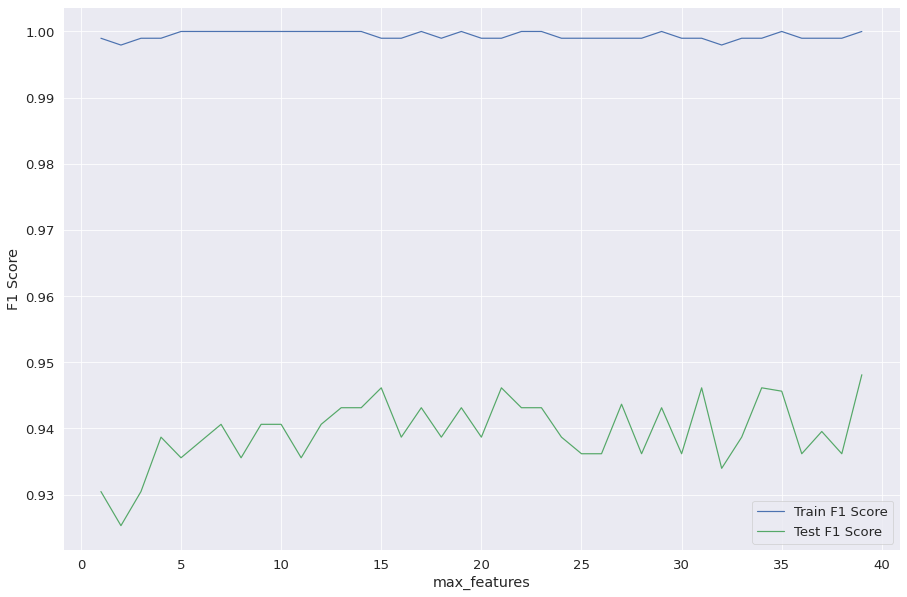

In [70]:
max_features = list(range(1,X_train.shape[1]))
trainf1 = []
testf1 = []
for i in max_features:
    rf = RandomForestClassifier(n_estimators = 32, max_depth=16, max_features=i, random_state=1,class_weight = "balanced")
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    
    f1train = f1_score(y_train, train_pred)
    trainf1.append(f1train)
    
    y_pred = rf.predict(X_test)
    
    f1test = f1_score(y_test, y_pred)
    testf1.append(f1test)

sns.set(context="paper", font_scale=1.5)
plt.figure(figsize=(15,10))
plt.plot(max_features, trainf1, 'b', label= 'Train F1 Score')
plt.plot(max_features, testf1, 'g', label= 'Test F1 Score')

plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('max_features')
plt.show()

n_estimators = 32 (bestntree)<br>
max_depth = 16 (bestndepth)<br>
max_features = 12 (bestnfeat)<br>

In [71]:
X = df_num.drop('Attrition_Yes', axis =1)
y = df_num['Attrition_Yes']

X_train,X_test, y_train, y_test= train_test_split(X,y, test_size = 0.30, random_state=1)

rftuned = RandomForestClassifier(n_estimators = 32, max_depth = 16 , max_features = 12, random_state=1, class_weight="balanced")
rftuned.fit(X_train, y_train)
y_pred = rftuned.predict(X_test)

In [72]:
rftunedaccuracy = accuracy_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
rftunedroc_auc = np.trapz(fpr, tpr)

rftunedf1_score = f1_score(y_test, y_pred)

rftunedrecall = recall_score(y_test, y_pred)

print('Model Accuracy: ', rftunedaccuracy)
print('ROC_AUC Score: ', rftunedroc_auc)
print('F1 Score: ', rftunedf1_score)
print('Recall: ', rftunedrecall)

Model Accuracy:  0.981103552532124
ROC_AUC Score:  0.05605381165919282
F1 Score:  0.9406175771971497
Recall:  0.8878923766816144


In [73]:
rftcm = confusion_matrix(y_test,y_pred)
print(rftcm)

[[1100    0]
 [  25  198]]


#Feature importance


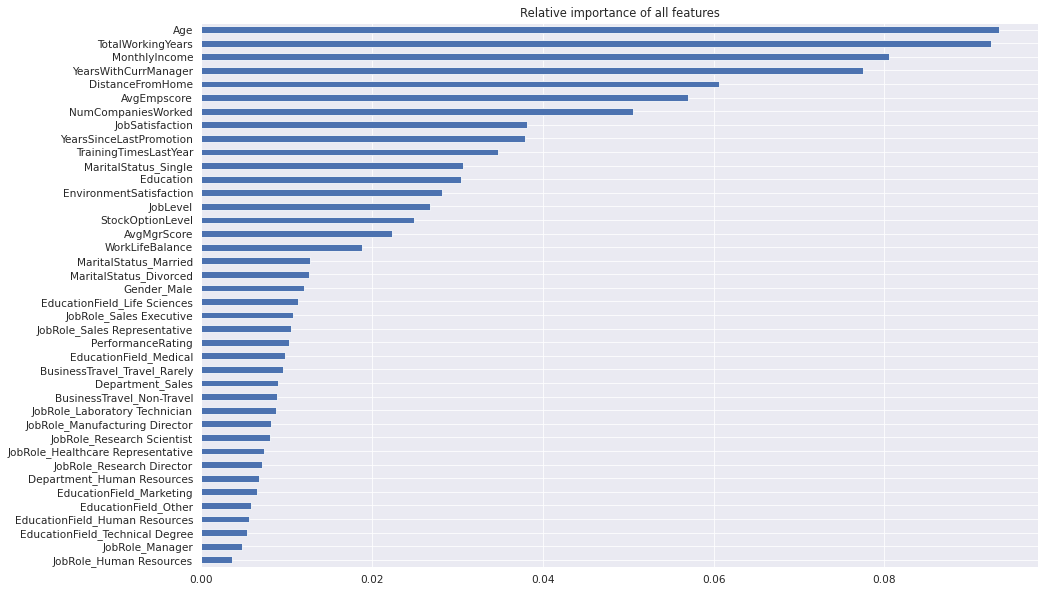

In [74]:
feature_importance=pd.DataFrame(rftuned.feature_importances_,index=X.columns,columns=['importance']).sort_values('importance',ascending=False)
plt.figure(figsize=(15,10))
sns.set(context="paper",font_scale=1.2)
feature_importance['importance'].plot(kind='barh')
plt.title('Relative importance of all features')
plt.gca().invert_yaxis()
plt.show()

#top 5 important features

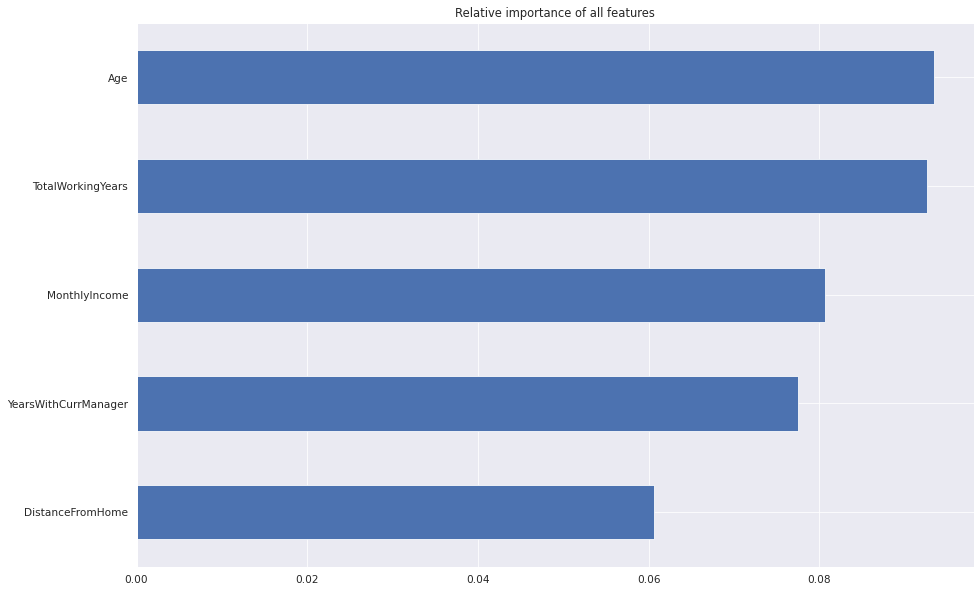

In [75]:
feature_importance=pd.DataFrame(rftuned.feature_importances_,index=X.columns,columns=['importance']).sort_values('importance',ascending=False)[0:5]
plt.figure(figsize=(15,10))
sns.set(context="paper",font_scale=1.2)
feature_importance['importance'].plot(kind='barh')
plt.title('Relative importance of all features')
plt.gca().invert_yaxis()
plt.show()

#from the graph we can see that the 5 important features


#SVM

In [76]:
X = df_num.drop('Attrition_Yes', axis =1)
y = df_num['Attrition_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

ss = preprocessing.StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [77]:
svm=SVC(random_state=1,class_weight='balanced')
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)

In [78]:
svmaccuacy=accuracy_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
svmroc_auc= np.trapz(fpr,tpr)
svm_f1score=f1_score(y_test,y_pred)
svmrecall=recall_score(y_test,y_pred)

In [79]:
print("Model Accuacy",svmaccuacy)
print("ROC_AUC sore",svmroc_auc) # Roc score have some issue . need to check that .
print("F1 score",svm_f1score)
print("sRecall",svmrecall)

Model Accuacy 0.9055177626606198
ROC_AUC sore 0.11580921320831634
F1 score 0.7524752475247525
sRecall 0.852017937219731


In [80]:
svmcm = confusion_matrix(y_test,y_pred)

In [81]:
print(svmcm)

[[1008   92]
 [  33  190]]


HYPER PARAMETER TUNNING

In [82]:
#optimistic C (regularisation parameter) with grid search cv
param_grid={'C':[0.1,0.5,1.0,10,20],'gamma':['auto','scale']}
grid=GridSearchCV(SVC(class_weight='balanced'),param_grid,refit=True,verbose=1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   22.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1.0, 10, 20],
                         'gamma': ['auto', 'scale']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [83]:
grid.best_estimator_

SVC(C=20, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [84]:
y_pred=grid.best_estimator_.predict(X_test)
svmtaccuracy=accuracy_score(y_test,y_pred)
fpr,tpr,threshold=roc_curve(y_test,y_pred)
svmtroc_auc=np.trapz(fpr,tpr)
svmtf1_score=f1_score(y_test,y_pred)
svmtrecall=recall_score(y_test,y_pred)

In [85]:
print("Model Accuracy",svmtaccuracy)
print("Roc_Auc score",svmtroc_auc)
print('F1 score',svmtf1_score)
print("Recall",svmtrecall)

Model Accuracy 0.9705215419501134
Roc_Auc score 0.06062984101100692
F1 score 0.9107551487414188
Recall 0.8923766816143498


In [86]:
svmtcm=confusion_matrix(y_test,y_pred)

In [87]:
print(svmtcm)

[[1085   15]
 [  24  199]]


#Model Evaluvation and Recommandation

Builded 6 models applying 3 different classification models <br>
Summarising scores from all 6 models

In [89]:
LogReg=(lraccuracy,lrroc_auc,lrf1_score,lrrecall)
Rf=(rfaccuracy,rfroc_auc,rff1_score,rfrecall)
Rft=(rftunedaccuracy,rftunedroc_auc,rftunedf1_score,rftunedrecall)
Svc=(svmaccuacy,svmroc_auc,svm_f1score,svmrecall)
Svct=(svmtaccuracy,svmtroc_auc,svmtf1_score,svmtrecall)

In [91]:
modelsummary=pd.DataFrame(data=(LogReg,Rf,Rft,Svc,Svct),columns=('Accuracy','Roc_Auc score','F1 score','Recall score')).mul(100).round(1).astype(str).add('%')
modelsummary.rename(index={0:'Logistic Regression(*Baseline*)',1:'RandomForest(*Baseline*)',2:'RandomForest(Tunned)',3:'support vector machine(*Baseline*)',4:'Support vetor machine(Tuuned)'},inplace=True)
# modelsummary['Run time']=(lrtime,rftime,rftuned,svmtime,svmtunedtime)

In [92]:
modelsummary

,Accuracy,Roc_Auc score,F1 score,Recall score
Logistic Regression(*Baseline*),68.9%,30.3%,43.5%,70.9%
RandomForest(*Baseline*),95.1%,91.1%,85.4%,85.2%
RandomForest(Tunned),98.1%,5.6%,94.1%,88.8%
support vector machine(*Baseline*),90.6%,11.6%,75.2%,85.2%
Support vetor machine(Tuuned),97.1%,6.1%,91.1%,89.2%


*#code have some issue with Roc score!*

Based on its f1 score of 94% and accuracy 98% i would like to suggest usage of Random forest model.